In [15]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from bdshare import get_hist_data #library for extracting stock data from DSE and CSE 
import bdshare

In [50]:
stock_data = get_hist_data('2021-06-06','2023-04-09','BATASHOE') # data after 2022-10-30 has not been updated 
pd.set_option('display.max_rows', None)
print(stock_data.to_string())

              symbol     ltp    high     low    open   close     ycp trade   value volume
date                                                                                     
2023-04-09  BATASHOE     963     974     962     970   969.4   958.9    17   0.202    208
2023-04-06  BATASHOE   959.3   959.3     955     955   958.9   959.3    25   0.845    882
2023-04-05  BATASHOE   959.9     970     950     950   959.3   959.9    21   0.602    628
2023-04-04  BATASHOE   951.2     965     951     965   959.9   959.2    59   1.033   1076
2023-04-03  BATASHOE     960     960     959   959.2   959.2   958.7     7   0.128    133
2023-04-02  BATASHOE   950.1     960   946.7   946.8   958.7   946.7    21   0.692    722
2023-03-30  BATASHOE     940   954.4     940   954.4   946.7   954.4    87   2.075   2181
2023-03-29  BATASHOE     951     964   946.5   946.5   954.4   964.4    15   0.053     56
2023-03-28  BATASHOE     965     970     950     970   964.4   943.1    37   1.134   1182
2023-03-27

In [51]:
#convert the closing prices to float 
stock = stock_data['close'].astype(float)

In [52]:
#convert the index to datetime
date = pd.to_datetime(stock_data.index)

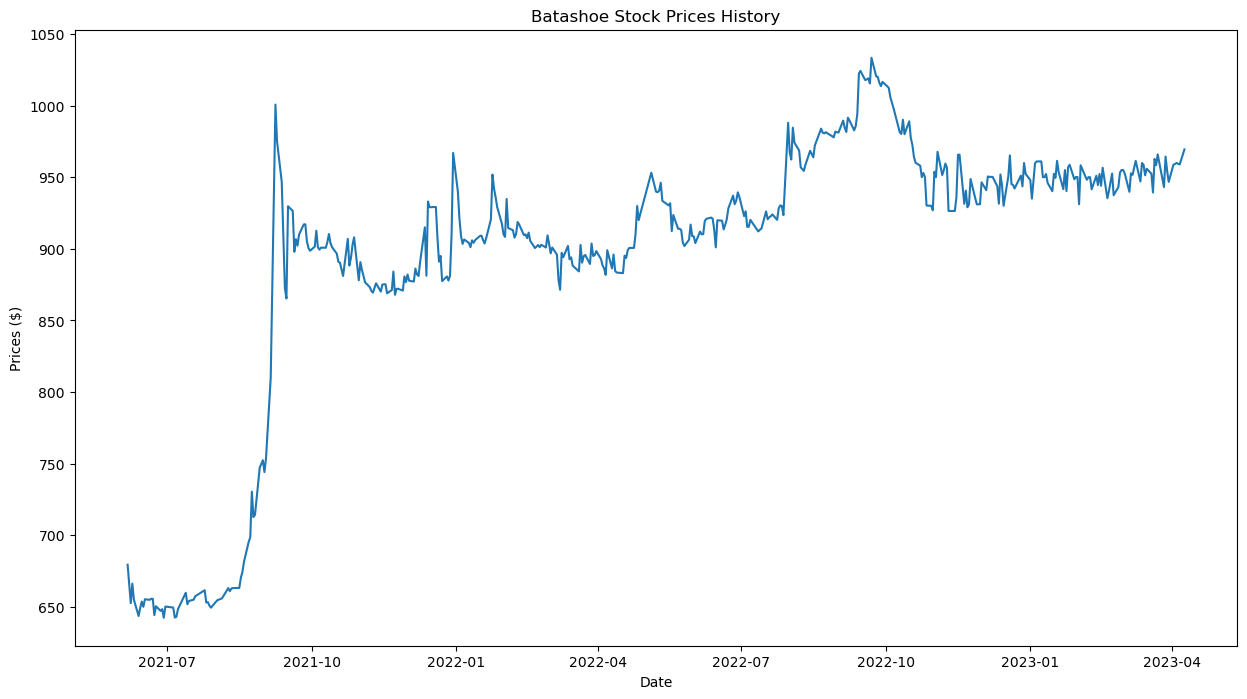

In [53]:
#plot the timeseries for BATA stock price
plt.figure(figsize=(15, 8))
plt.title('Batashoe Stock Prices History')
plt.plot(date, stock)
plt.xlabel('Date')
plt.ylabel('Prices ($)')
#plt.xticks(rotation=45)
#plt.yticks(rotation = 45)
plt.show()

In [54]:
close_prices = stock
values = np.flip(close_prices.values, axis = 0) #there are 380 datapoints in total arranged from 2021 to 2022 
training_data_len = math.ceil(len(values)* 0.8) #will be taking 80% of the dataset (304 datapoints) 

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(values.reshape(-1,1))

In [55]:
train_data = scaled_data[0: training_data_len, :]#extracting the first 304 datapoints 

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #contains the first 244 datapoints (304-60)
    y_train.append(train_data[i, 0]) #contains the last 244 datapoints 
    #we observe the first 3 months to predict the next 3 months(60 points) 
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # reshaped to dim(240,60,1) 
#(240: our sample size, 60 timesteps: we want the model to look back 60 timesteps to predict the next 60, 
#features: the timesteps are taken from 1 ts data, if we wanted to include the historic data of other 
#ts plots we would increase the features accordingly)

In [56]:
test_data = scaled_data[training_data_len-60: , : ] #contains 136 datapoints 
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0]) #contains 76 datapoints (136-60)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [57]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(20))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 20)                2020      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 123,241
Trainable params: 123,241
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
300/300 [==============================] - 6s 13ms/step - loss: 0.0109
Epoch 2/3
300/300 [==============================] - 4s 13ms/step - loss: 0.0029
Epoch 3/3
300/300 [==============================] - 4s 14ms/step - loss: 0.0035


In [59]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3/3 [==============================] - 1s 28ms/step


1.7057994371049827

In [60]:
data = pd.DataFrame(stock_data.loc[:, 'close'].iloc[::-1]) #need to flip the dataframe and arrange from 2021 to 2022
#data = stock_data.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['predictions'] = predictions

C:\Users\Mir Info\AppData\Local\Temp\ipykernel_10988\403298629.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


C:\Users\Mir Info\AppData\Local\Temp\ipykernel_10988\2375077151.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['close'] = validation['close'].astype(float)
C:\Users\Mir Info\AppData\Local\Temp\ipykernel_10988\2375077151.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = validation['predictions'].astype(float)


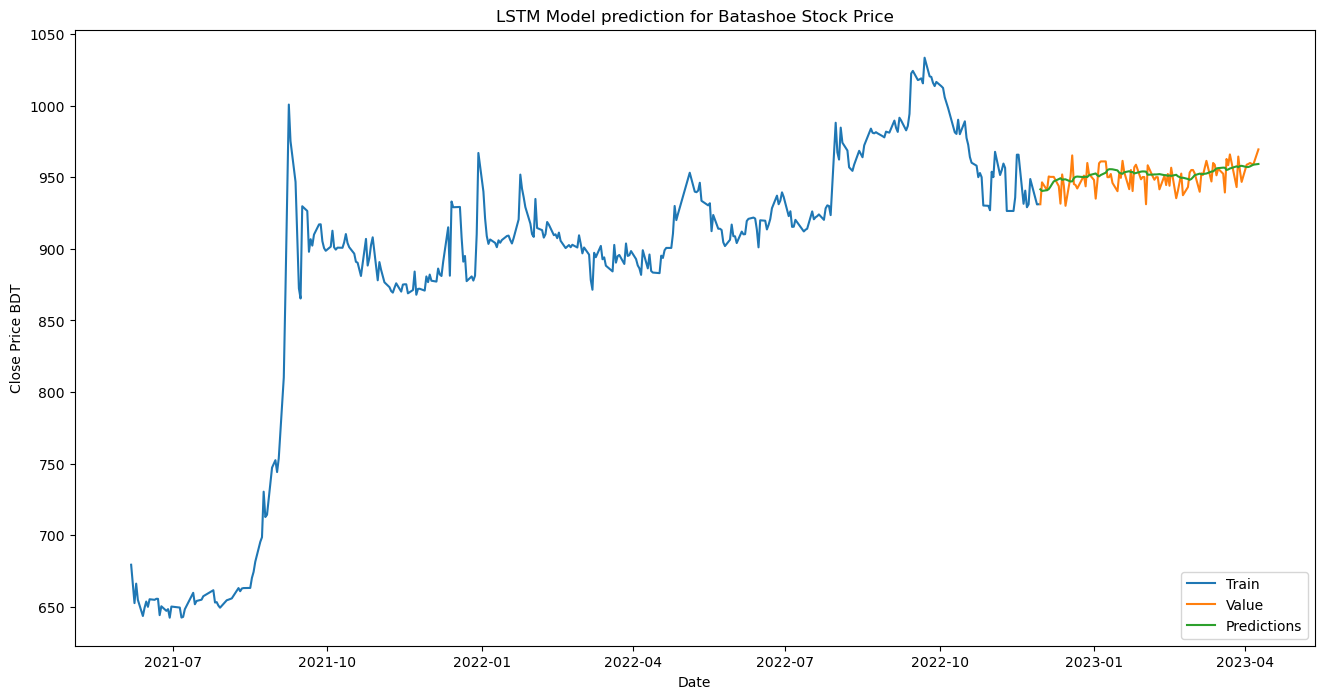

In [61]:
plt.figure(figsize=(16,8))
plt.title('LSTM Model prediction for Batashoe Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price BDT')

#convert the closing prices to float 
trainstock = train['close'].astype(float)
#convert the index to datetime 
traindate = pd.to_datetime(train.index)
plt.plot(traindate, trainstock)

validdate = pd.to_datetime(validation.index)
close = validation['close'].astype(float)
pred = validation['predictions'].astype(float)
validation['close'] = validation['close'].astype(float)
validation['predictions'] = validation['predictions'].astype(float)
plt.plot(validdate, validation[['close', 'predictions']])
plt.legend(['Train', 'Value', 'Predictions'], loc='lower right')
plt.show()

In [62]:
pd.set_option('display.max_rows', None)
print(validation)

            close  predictions
date                          
2022-11-30  931.1   941.521118
2022-12-01  946.4   940.367737
2022-12-04  940.9   940.937256
2022-12-05  950.5   941.629395
2022-12-06  950.2   943.332397
2022-12-07  950.2   945.250977
2022-12-08  950.2   947.072937
2022-12-11  943.7   948.648193
2022-12-12  931.5   949.263184
2022-12-13  951.9   948.137390
2022-12-14  944.3   948.441589
2022-12-15  930.0   948.482544
2022-12-18  950.5   946.991089
2022-12-19  965.2   947.099365
2022-12-20  945.2   949.330200
2022-12-21  944.5   950.217773
2022-12-22  942.1   950.430481
2022-12-26  951.1   950.041565
2022-12-27  943.6   950.332214
2022-12-28  959.9   950.089844
2022-12-29  952.3   951.335205
2023-01-01  948.0   952.276550
2023-01-02  935.0   952.587280
2023-01-03  946.9   951.254944
2023-01-04  959.7   950.568542
2023-01-05  961.0   951.487610
2023-01-08  961.0   953.138916
2023-01-09  950.0   954.967773
2023-01-10  950.0   955.557861
2023-01-11  952.2   955.556763
2023-01-